In [1]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

## Start of code

In [2]:
#Initialize pyspark
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012: Assignment 1 - Q1") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
#Prepare for day extraction 
from datetime import datetime

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

def get_day(date):
    if date == "": return None
    return days[datetime.strptime(date.strip(), "%d/%b/%Y").weekday()]

In [4]:
#Load and prepare data
from pyspark.sql import Row
from pyspark.sql.functions import split, regexp_extract

log_file =  spark.read.text("../Data/NASA_access_log_Jul95.gz").cache()
# https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/4438435960036599/2202577924924539/latest.html
log_data = log_file.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*(\d\d/\w{3}/\d{4})', 1).alias('date'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size'))


In [5]:
from pyspark.sql.functions import count, mean, col

day_count_df = log_data.groupBy("date").agg(count("date").alias("n_count")).sort("date")

#### 1A - Average number of requests for the seven days in the week

In [6]:
day_count_df = day_count_df.rdd.map(lambda x: Row(day=get_day(x.date), n_count=x.n_count, date=x.date)).toDF()
df_avg = day_count_df.filter(day_count_df.day != "null").groupBy("day").agg(mean("n_count").alias("m_count"))

In [7]:
df_avg.show()

+---+-------+
|day|m_count|
+---+-------+
|Sun|45647.5|
|Mon|75421.0|
|Thu|90859.0|
|Sat|46095.0|
|Wed|79674.5|
|Tue|69460.0|
|Fri|65771.5|
+---+-------+



#### 1B - Visualization of results 

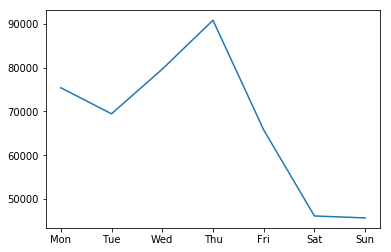

In [8]:
#Displaying data in pie chart
days_c = {r.day:r.m_count for r in df_avg.collect() if r.day != None}

import matplotlib.pyplot as plt

days_c = {key:days_c[key] for key in days}
plt.plot(list(days_c.keys()), list(days_c.values()))
plt.show()

#### 1C - Top 20 most requested .gif images

In [9]:
from pyspark.sql.functions import desc 

gif_count = log_data.filter(log_data.path.endswith(".gif")).groupBy("path").agg(count("path").alias("n_count")).sort(desc("n_count")).limit(20)

In [10]:
gif_count.show(20, False)

+---------------------------------------------------+-------+
|path                                               |n_count|
+---------------------------------------------------+-------+
|/images/NASA-logosmall.gif                         |111087 |
|/images/KSC-logosmall.gif                          |89530  |
|/images/MOSAIC-logosmall.gif                       |60300  |
|/images/USA-logosmall.gif                          |59845  |
|/images/WORLD-logosmall.gif                        |59325  |
|/images/ksclogo-medium.gif                         |58616  |
|/images/launch-logo.gif                            |40841  |
|/images/ksclogosmall.gif                           |33555  |
|/history/apollo/images/apollo-logo1.gif            |31052  |
|/shuttle/countdown/count.gif                       |22189  |
|/shuttle/countdown/count70.gif                     |20921  |
|/images/launchmedium.gif                           |20788  |
|/shuttle/missions/sts-71/sts-71-patch-small.gif    |19832  |
|/shuttl

#### 1D - Visualization of results

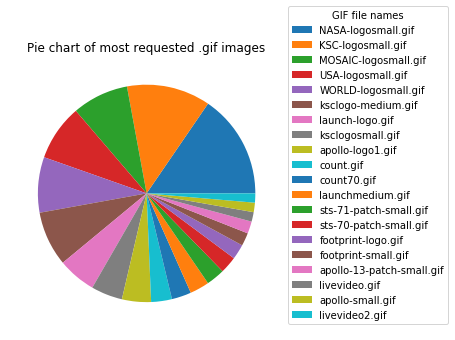

In [11]:
gif_c = {r.path.split("/")[-1]:r.n_count for r in gif_count.collect()}

#https://matplotlib.org/gallery/pie_and_polar_charts/pie_features.html
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(list(gif_c.values()))
ax.legend(wedges, list(gif_c.keys()),
          title="GIF file names",
          loc="lower left",
          bbox_to_anchor=(1, 0))

ax.set_title("Pie chart of most requested .gif images")

plt.show()
